In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.tree import export_graphviz
from IPython.display import display
from graphviz import Source
import pydotplus
import collections
import seaborn
import json 
import xarray as xr
import pandas as pd
from google.colab import drive
import os,sys,glob
import datetime as dt
import numpy as np

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import itertools 

!pip install numpy scipy scikit-learn
!pip install forestci



     |████████████████████████████████| 6.8MB 5.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
df = pd.read_excel('/content/athlete_events.xlsx')
df = df[df['Age'].notna()]
df = df.replace(np.nan,'None',regex=True)


In [4]:
df_income = pd.read_csv('/content/processed_income_data.csv')
df_income = df_income.rename(columns={'Code':'NOC'})
df_final = pd.merge(df,df_income,how='left',on=['Year','NOC']).dropna()

In [ ]:
#prior medal winner (FIX!!!)

df_test = df_final.reset_index()[['ID','Medal','Year']]
df_first_medal = df_test.groupby(['ID']).apply(lambda g: g[g.Medal != 'None'].Year.min()).to_frame()
display(df_first_medal.head(50))


KeyboardInterrupt: ignored

In [5]:

df_final['Medal'] = df_final['Medal'].astype('category')

grouped_summer = df_final[df_final['Season']=='Summer'].groupby(['Sport','Sex','Income','Age'])['Medal'].value_counts(normalize=True).to_frame()
grouped_winter = df_final[df_final['Season']=='Winter'].groupby(['Sport','Sex','Income','Age'])['Medal'].value_counts(normalize=True).to_frame()

levels_sum = [grouped_summer.index.levels[0].values, grouped_summer.index.levels[1].values, grouped_summer.index.levels[2].values,np.arange(15,61),\
          df_final.Medal.unique()]
levels_win = [grouped_winter.index.levels[0].values, grouped_winter.index.levels[1].values, grouped_winter.index.levels[2].values,np.arange(15,61),\
df_final.Medal.unique()]
new_index_sum = pd.MultiIndex.from_product(levels_sum, names=grouped_summer.index.names)
new_index_win = pd.MultiIndex.from_product(levels_win, names=grouped_winter.index.names)

grouped_summer = grouped_summer.reindex(new_index_sum, fill_value=0)
grouped_winter = grouped_winter.reindex(new_index_win, fill_value=0)
grouped_summer = pd.concat({'Summer': grouped_summer}, names=['Season'])
grouped_winter = pd.concat({'Winter': grouped_winter}, names=['Season'])



In [6]:

#feature Label ML approach



mapping_inc = {'L':1.0,'LM':2.0,'UM':3.0,'H':4.0}
mapping_gender = {'M':0.0,'F':1.0}
df_final['Income'] = df_final['Income'].to_frame().applymap(lambda s: mapping_inc.get(s) if s in mapping_inc else s)
df_final['Sex'] = df_final['Sex'].to_frame().applymap(lambda s: mapping_gender.get(s) if s in mapping_gender else s)




In [ ]:
max_depth = range(3,25,2)
years = [1990,1985,1980,1975,1970,1965,1960]
display(list(itertools.product(max_depth,years)))

[(3, 1990),
 (3, 1985),
 (3, 1980),
 (3, 1975),
 (3, 1970),
 (3, 1965),
 (3, 1960),
 (5, 1990),
 (5, 1985),
 (5, 1980),
 (5, 1975),
 (5, 1970),
 (5, 1965),
 (5, 1960),
 (7, 1990),
 (7, 1985),
 (7, 1980),
 (7, 1975),
 (7, 1970),
 (7, 1965),
 (7, 1960),
 (9, 1990),
 (9, 1985),
 (9, 1980),
 (9, 1975),
 (9, 1970),
 (9, 1965),
 (9, 1960),
 (11, 1990),
 (11, 1985),
 (11, 1980),
 (11, 1975),
 (11, 1970),
 (11, 1965),
 (11, 1960),
 (13, 1990),
 (13, 1985),
 (13, 1980),
 (13, 1975),
 (13, 1970),
 (13, 1965),
 (13, 1960),
 (15, 1990),
 (15, 1985),
 (15, 1980),
 (15, 1975),
 (15, 1970),
 (15, 1965),
 (15, 1960),
 (17, 1990),
 (17, 1985),
 (17, 1980),
 (17, 1975),
 (17, 1970),
 (17, 1965),
 (17, 1960),
 (19, 1990),
 (19, 1985),
 (19, 1980),
 (19, 1975),
 (19, 1970),
 (19, 1965),
 (19, 1960),
 (21, 1990),
 (21, 1985),
 (21, 1980),
 (21, 1975),
 (21, 1970),
 (21, 1965),
 (21, 1960),
 (23, 1990),
 (23, 1985),
 (23, 1980),
 (23, 1975),
 (23, 1970),
 (23, 1965),
 (23, 1960)]

In [7]:
#decision tree regression 
#iterates over several possible max_depth parameter values
#finds parameter that gives the highest test score

# tree = DecisionTreeClassifier(max_depth=3)
# tree.fit(X_train,y_train)
# train_score = tree.score(X_train,y_train)
# test_score = tree.score(X_test,y_test)
# display(test_score)
# display(train_score)
# tree_rules = export_text(tree, feature_names=list(['Age','Age_sq','Age_cube']))
# display(tree_rules)
import forestci as fci
from scipy.interpolate import splrep
from scipy.interpolate import splev
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

#grouped = grouped.unstack(level=[4,5])
#display(grouped.unstack(level=[4,5]).loc[('Summer','Archery','M','H')].to_frame())


sports = df_final.Sport.unique().tolist()
sports_r2 = np.empty_like(sports)
mapping_inc_reverse = {1.0:'L',2.0:'LM',3.0:'UM',4.0:'H'}
mapping_gender_reverse = {0.0:'M',1.0:'F'}
#sports = ['Athletics']
max_depth = range(3,25,2)
years = [1990,1985,1980,1975,1970,1965,1960]

for sport in enumerate(sports): 
  test_R2 = []
  param_options = list(itertools.product(max_depth,years))
  for params in param_options:
    X1 = df_final[(df_final['Sport']==sport[1]) & (df_final['Year']>params[1])][['Sex','Age','Income']].to_numpy()
    Y1 = df_final[(df_final['Sport']==sport[1]) & (df_final['Year']>params[1])].Medal.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X1,Y1, test_size=0.10)

    clf = RandomForestClassifier(n_estimators=100, max_depth=params[0],
        min_samples_leaf= 2,criterion='gini', random_state=0)
    classifier = clf.fit(X_train,y_train)
    test_score = clf.score(X_test, y_test).mean()
    #print("trying max depth: {}".format(params[0]))
    #print("score using athletes since {} :{}".format(params[1],test_score))
    test_R2.append(test_score)

  max_testscore= max(test_R2)
  sports_r2[sport[0]] = max_testscore
  print('maximum score for test set: {} using max_depth of {}'.format(max_testscore, \
        param_options[test_R2.index(max_testscore)]))
  X1 = df_final[(df_final['Sport']==sport[1]) & (df_final['Year']>param_options[test_R2.index(max_testscore)][1])][['Sex','Age','Income']].to_numpy()
  Y1 = df_final[(df_final['Sport']==sport[1]) & (df_final['Year']>param_options[test_R2.index(max_testscore)][1])].Medal.to_numpy()
  X_train, X_test, y_train, y_test = train_test_split(X1,Y1, test_size=0.15)
  clf = RandomForestClassifier(n_estimators=300, max_depth=param_options[test_R2.index(max_testscore)][0],
      min_samples_leaf= 2,criterion='gini', random_state=0)
  classifier = clf.fit(X_train,y_train)
  for Sex in [ 1.0, 0.0 ]:
    for Income in [ 1.0, 2.0, 3.0, 4.0 ]:
        df = pd.DataFrame({'Sex':Sex,'Age':np.arange(15,61).tolist(),'Income':Income,})
        predictions = classifier.predict_proba(df)

        window_size = 15
        poly_order = 3
        IX = np.arange(0,46)

        prediction_smoothed = interp1d(IX,predictions[:,0],kind='linear')
        IY_0 = savgol_filter(prediction_smoothed(IX), window_size, poly_order)

        prediction_smoothed = interp1d(IX,predictions[:,1],kind='linear')
        IY_1 = savgol_filter(prediction_smoothed(IX), window_size, poly_order)

        prediction_smoothed = interp1d(IX,predictions[:,2],kind='linear')
        IY_2 = savgol_filter(prediction_smoothed(IX), window_size, poly_order)

        prediction_smoothed = interp1d(IX,predictions[:,3],kind='linear')
        IY_3 = savgol_filter(prediction_smoothed(IX), window_size, poly_order)

        IY_0[IY_0 < 0]=0
        IY_1[IY_1 < 0]=0
        IY_2[IY_2 < 0]=0
        IY_3[IY_3 < 0]=0

        IY_0[IY_0 > 1]=1
        IY_1[IY_1 > 1]=1
        IY_2[IY_2 > 1]=1
        IY_3[IY_3 > 1]=1

        IY_sum = IY_0 + IY_1 + IY_2 + IY_3
        IY_0 = IY_0/IY_sum
        IY_1 = IY_1/IY_sum
        IY_2 = IY_2/IY_sum
        IY_3 = IY_3/IY_sum
        df = np.ndarray.flatten(np.stack((IY_2,IY_0,IY_1,IY_3),axis=1))
        df = np.expand_dims(df,axis=1)
        # if (max_testscore < 0.85):
        #   df[:] = np.NaN
        try:
          grouped_summer.loc[('Summer',sport[1],mapping_gender_reverse[Sex],mapping_inc_reverse[Income])] = df
        except:
          grouped_winter.loc[('Winter',sport[1],mapping_gender_reverse[Sex],mapping_inc_reverse[Income])] = df
        #variance = fci.random_forest_error(clf,X_train, df)


Failed to import duecredit due to No module named 'duecredit'
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


maximum score for test set: 0.7931034482758621 using max_depth of (3, 1975)
maximum score for test set: 0.8909090909090909 using max_depth of (13, 1985)
maximum score for test set: 0.9503239740820735 using max_depth of (5, 1965)
maximum score for test set: 0.7489539748953975 using max_depth of (23, 1965)
maximum score for test set: 0.9473684210526315 using max_depth of (3, 1990)
maximum score for test set: 0.9227467811158798 using max_depth of (5, 1980)
maximum score for test set: 0.9585987261146497 using max_depth of (15, 1990)
maximum score for test set: 0.925 using max_depth of (17, 1960)
maximum score for test set: 0.9730458221024259 using max_depth of (11, 1975)
maximum score for test set: 0.7934782608695652 using max_depth of (11, 1985)
maximum score for test set: 0.9041095890410958 using max_depth of (5, 1960)
maximum score for test set: 0.8755555555555555 using max_depth of (7, 1960)
maximum score for test set: 0.9818181818181818 using max_depth of (11, 1970)
maximum score for 

In [ ]:
sports_df = pd.DataFrame(data=np.stack((sports,sports_r2),axis=1),columns=['Sport','Accuracy']).set_index('Sport')
accuracy_json = sports_df.transpose().to_json()
with open('sports_classification_accuracy.txt','w') as outfile:
  json.dump(accuracy_json,outfile)

AttributeError: ignored

In [8]:

grouped = pd.concat([grouped_summer,grouped_winter])
#display(grouped.loc[])
import json
levels = len(grouped.index.levels)
dicts = [{} for i in range(levels)]
print(dicts)
last_index = None
for index,value in grouped.itertuples():
    

    if not last_index:
        last_index = index

    for (ii,(i,j)) in enumerate(zip(index, last_index)):
        if not i == j:
            ii = levels - ii -1
            dicts[:ii] =  [{} for _ in dicts[:ii]]
            break

    for i, key in enumerate(reversed(index)):
        dicts[i][key] = value
        value = dicts[i]

    last_index = index


result = json.dumps(dicts[-1])
print(result)

with open('athlete_medal_probabilities.txt','w') as outfile:
  json.dump(result,outfile)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(clf.classes_)

['Bronze' 'Gold' 'None' 'Silver']


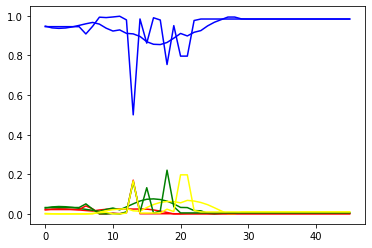

In [ ]:


window_size = 15
poly_order = 3
IX = np.arange(0,46)

prediction_smoothed = interp1d(IX,predictions[:,0],kind='linear')
IY_0 = savgol_filter(prediction_smoothed(IX), window_size, poly_order)

prediction_smoothed = interp1d(IX,predictions[:,1],kind='linear')
IY_1 = savgol_filter(prediction_smoothed(IX), window_size, poly_order)

prediction_smoothed = interp1d(IX,predictions[:,2],kind='linear')
IY_2 = savgol_filter(prediction_smoothed(IX), window_size, poly_order)

prediction_smoothed = interp1d(IX,predictions[:,3],kind='linear')
IY_3 = savgol_filter(prediction_smoothed(IX), window_size, poly_order)

IY_0[IY_0 < 0]=0
IY_1[IY_1 < 0]=0
IY_2[IY_2 < 0]=0
IY_3[IY_3 < 0]=0

IY_sum = IY_0 + IY_1 + IY_2 + IY_3
IY_0_fit = IY_0/IY_sum
IY_1_fit = IY_1/IY_sum
IY_2_fit = IY_2/IY_sum
IY_3_fit = IY_3/IY_sum

plt.plot(IX,IY_0_fit,color='red')
plt.plot(IX,IY_1_fit,color='green')
plt.plot(IX,IY_2_fit,color='blue')
plt.plot(IX,IY_3_fit,color='yellow')
plt.plot(IX,predictions[:,0],color='red')
plt.plot(IX,predictions[:,1],color='green')
plt.plot(IX,predictions[:,2],color='blue')
plt.plot(IX,predictions[:,3],color='yellow')



In [ ]:
print(variance)

[0.00071867 0.00071867 0.00071867 0.00071867 0.00071867 0.00071867
 0.00071867 0.00071867 0.00071867 0.00071867 0.00071867 0.00071867
 0.00071867 0.00071867 0.00071867 0.00071867 0.00071867 0.00069495
 0.00071867 0.00113456 0.00071867 0.00071867 0.00047244 0.00071867
 0.00071867 0.00086802 0.00086802 0.00086802 0.00086802 0.00086802
 0.00086802 0.00086802 0.00086802 0.00086802 0.00086802 0.00086802
 0.00086802 0.00086802 0.00086802 0.00086802 0.00086802 0.00086802
 0.00086802 0.00086802 0.00086802 0.00086802]


In [ ]:
display(tree.feature_importances_)

array([0.41071452, 0.19080765, 0.39847783])